# Modul 3: KI Deep Dive
## Hertie School of Governance
## November 2024
## Practical Exercise


# Textklassifikation zur Spam-Erkennung

In [1]:
# Vorbereitung
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/janbatzner/Hertie_KI-Modul_SPAM_Classifier.git
    # Wir kopieren die notwendigen Files von GitHub und installieren packages mit pip
    !cp -r "Hertie_KI-Modul_SPAM_Classifier/data" "Hertie_KI-Modul_SPAM_Classifier/tools.py" .
    !pip install -r "Hertie_KI-Modul_SPAM_Classifier/colab-requirements.txt"
    # Neustart der Runtime: falls nötig das "#" der unteren beiden Zeilen entfernen
    #import os
    #os.kill(os.getpid(), 9)

fatal: destination path 'Hertie_KI-Modul_SPAM_Classifier' already exists and is not an empty directory.


## Aufgabe
Wir möchten einen Spam-Detektor entwickeln, der anhand von Beispielen für Spam-E-Mails (z. B. von Nutzern markiert) und Beispielen für reguläre (nicht-spam, auch "ham" genannt) E-Mails lernt, wie neue, noch nicht gesehene E-Mails als Spam oder Nicht-Spam markiert werden können.
## Daten
Wir werden das öffentliche E-Mail-Korpus [SpamAssassin](https://spamassassin.apache.org/) verwenden. Dieses Datenset enthält ungefähr 6.000 gelabelte E-Mails mit einem Spam-Anteil von etwa 30 %. Wenn Sie mehr über dieses Datenset erfahren möchten, schauen Sie sich [dies](https://spamassassin.apache.org/old/publiccorpus/) an. (*Hinweis: Textdatensätze werden als Korpora bezeichnet und Muster als Dokumente.*)
Das Datenset wurde für Sie heruntergeladen und ist im *data*-Ordner verfügbar.
## Überblick über das Notebook
1. Laden der Daten
2. Textvorverarbeitung
3. Datenexploration
4. Feature Engineering
5. Aufbau eines Spam-Detektors
6. Was hat unser Modell gelernt?

# **(1) Laden der Daten**

In [2]:
# Lade die Helferfunktionen, Libraries, und Daten
# In der Library "Tools" haben wir alle Funktionen abgelegt, die wir heute brauchen. Falls Sie sich für den ganzen Code interessieren, schauen Sie gerne in unser GitHub.
import tools
df = tools.load_data()

Data loaded.
Data size: (5832, 2)


Lassen Sie uns jetzt einige E-Mails im Datensatz genauer betrachten! Wir nehmen hierfür eine Stichprobe von 3 E-Mails (sample). Verändern Sie den Code und passen die Zahl nach Belieben an.

Die Label sind:
- 0 = Kein Spam / "Ham"
- 1 = Spam

In [3]:
df.sample(3)

,label,text
4055,0,"Robert Harley:\n>It is perfectly obvious that (heterosexual) promiscuity is exactly, \n>precisely identical between males and females.\n\nYeah, assuming approximately equal populations.\nBut that obscures the different modes of\npromiscuity. Both the person who gives sex for\nmoney or power or companionship and the person\nwho uses money and power and companionship to\nget sex are promiscuous, in the broadest sense\nof the word. But their motives and behavior are\nquite different.\n\nLangur monkeys were the example in the cited\narticle. ""Dominant males .. kill babies that\nare not their own."" ""The dominant male monkey\n.. seeks to defend his harem of females."" But\ncozying up to the current dominant male isn't\nthe best strategy for female langurs, because\n""dominant males are dethroned by rivals every\n27 months or so."" ""By mating with as many\nextra-group males as possible, female langurs\nensure their offspring against infanticide,""\nby the male who is likely next to rule the\nroost.\n\nMaybe it's just me, but that doesn't paint a\npicture of carefree females engaged in joyously\npromiscuous couplings. The dom cab driver who\nis taking her two boy toys to New Orleans is a\nbetter picture of that. ;-)\n\n\n\n\n\n_________________________________________________________________\nChat with friends online, try MSN Messenger: http://messenger.msn.com"
844,1,"Y O U R last chance for \n\nY O U R $3000.00 INCOME per WEEK!\n\n\nGive Me 5 Minutes, And I'll Show You\nHow To Flood Your Bank Account With Serious Cash,\n \nDID YOU MAKE $12,000 LAST MONTH\nIF NOT, YOU NEED TO JOIN US TODAY!\n\n- FREE Turnkey Marketing System (a $2500 Value)\n- FREE Ready-to-Use ""Order-Pulling"" Ads & Sales Letters\n- Earn $1,000 CASH on Each and Every Sale to Infinity!\n- Work From Home and Live the ""1-Minute"" Commute\n- Plug Into Our Duplicate-able 3-Step Success System\n- YOU receive FULL live SUPPORT! For free!\n- Secure Your Financial Freedom Starting Today\n- Buy Your Dream House and Dream Car! \n- Amazing Support System guarantees YOU to SUCCEED!\n- EVERYBODY is a Prospect - 100% Cash Machine !\n- EVERYBODY can do it!\n\nNO hype ! All legal !\nUSA and Canada ONLY !\n\n\nRequest more free info NOW! \nsend an email to: Plutoristal@excite.com\n\nwith ""SEND INFO"" in the subject line!!\n(do NOT click REPLY!)\n\n\n\n\nTo remove, please send an email with ""REMOVE"" \nin the subject line to the same email address (above). -\n\n\n--DeathToSpamDeathToSpamDeathToSpam--\n\n\n-------------------------------------------------------\nThis sf.net email is sponsored by:ThinkGeek\nWelcome to geek heaven.\nhttp://thinkgeek.com/sf\n_______________________________________________\nSpamassassin-Sightings mailing list\nSpamassassin-Sightings@lists.sourceforge.net\nhttps://lists.sourceforge.net/lists/listinfo/spamassassin-sightings"
2137,0,"Halloechen!\n\nOn Dienstag, 27. August 2002 05:41 schrieben Sie:\n> [Question about require tag]\n\nOops, sorry. Now I found out that there is a noewsgroup ...\n:-)\n\nTschoe,\nTorsten.\n\n_______________________________________________\nRPM-List mailing list <RPM-List@freshrpms.net>\nhttp://lists.freshrpms.net/mailman/listinfo/rpm-list"


Jetzt überprüfen wir die Anzahl der Stichproben pro Klasse in den Daten. Wir wollen also wissen, wie die Verteilung der E-Mails zwischen den Labels **Spam** und **Nicht-Spam** ist.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: proportion, dtype: float64




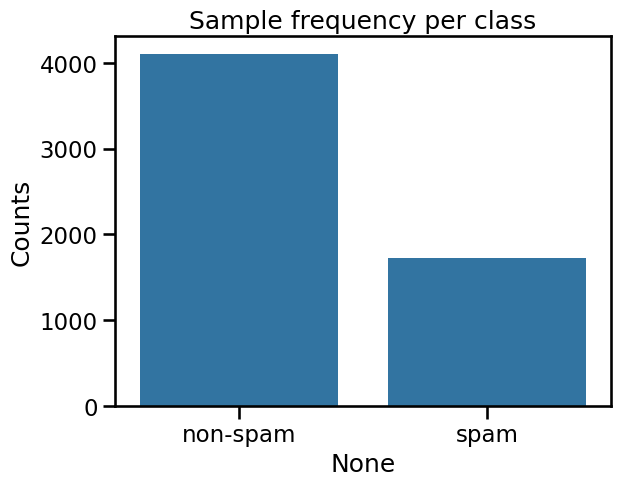

In [4]:
tools.plot_class_frequency(df)

## **(2) Textvorverarbeitung**

Eine gute Textvorverarbeitung ist ein wesentlicher Bestandteil jedes NLP-Projekts! Unser Ziel hier ist es, ein Modell zu entwickeln, das Nicht-Spam von Spam unterscheidet. Die Idee ist, Rohtext zu "bereinigen" und zu "standardisieren", bevor wir ihn unserem maschinellen Lernmodell zuführen. Wir müssen dabei so viele "informative" Wörter wie möglich behalten, während wir die "uninformativen" verwerfen. Das Entfernen unnötiger Inhalte, also des "Rauschens", aus unseren Texten wird dazu beitragen, die Genauigkeit unserer Modelle zu verbessern.

Hier sind einige wichtige Punkte:
* HTML-Tags
* URLs
* E-Mail-Adressen
* Satzzeichen, Ziffern (z. B. 2002, 1.1, ...)
* Mehrfaches Leerzeichen
* Groß-/Kleinschreibung (z. B. Hund vs hund, ...)
* Englische STOPWORDS (z. B. a, is, my, i, all, and, by...)
* ...
Die *clean_corpus*-Funktion unten kümmert sich um all das!

In [5]:
df = tools.clean_corpus(df)
print('Data cleaned')

Data cleaned


In [6]:
# Nun schauen wir uns die "cleaned" Beispiele einmal an!
tools.show_clean_text(df)


Original document:

Hi,  =09I made a spec file for it some weeks ago, maybe it can be included in = fresh.=20 If not,
at least you can use it...  I'm attaching it here...  Hope it might be some use for you, does the
trick for me. Might be an old= =20 version though, but should still work  Nick     On Wednesday 04
September 2002 21:00, Doug Stewart wrote: > I've noted that there are packaged versions of >
Blackbox and hackedbox available from FreshRPMs.  What > about FluxBox? http://fluxbox.sf.net > >
I'd certainly enjoy a packaged version, since its > creators seem hesitant to provide .rpms (.debs,
yes, > but no .rpms). > > .Doug > > __________________________________________________ > Do You
Yahoo!? > Yahoo! Finance - Get real-time stock quotes > http://finance.yahoo.com > >
_______________________________________________ > RPM-List mailing list <RPM-List@freshrpms.net> >
http://lists.freshrpms.net/mailman/listinfo/rpm-list

Cleaned document:

spec file weeks maybe included fresh att

## **(3) Datenexploration**
### 3.1 Häufige Wörter (frequent words)

Welche Wörter unterscheiden Spam von Nicht-Spam? Was macht Spam aus? Können wir die Wörter in einem Text identifizieren, die am aussagekräftigsten die E-Mail sind?  

Lassen Sie uns die häufigsten Wörter in Spam und Nicht-Spam finden.

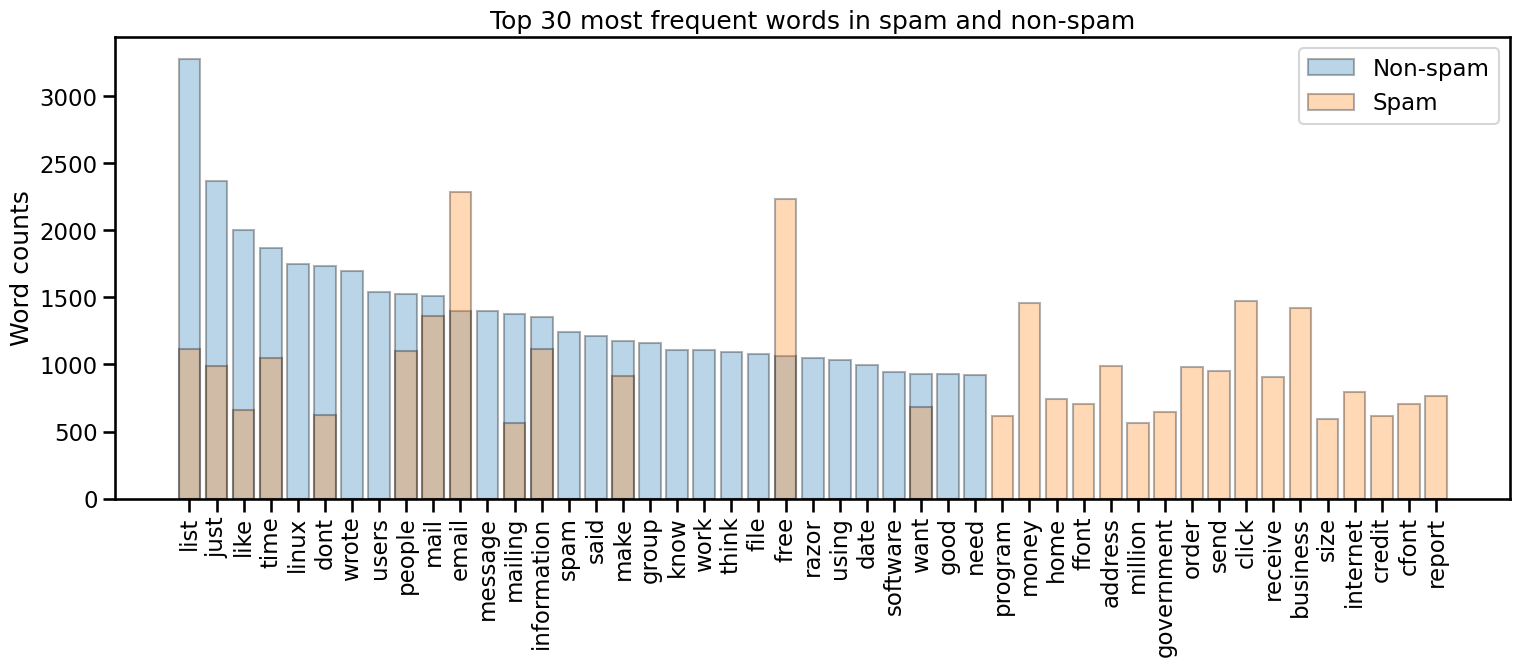

In [7]:
# Bestimmung der N häufigsten Wörter. Passen Sie N gerne nach Ihren Belieben an!
tools.plot_most_common_words(df=df, N=30)

**Häufige Spam Wörter sind beispielsweise**:

* click
* money
* business
* free
* email


**Häufige Nicht-Spam Wörter sind beispielsweise**:
* list
* linux
* message
* wrote
* users
* spam
* said
* file
* good

### 3.2 Können wir Spam-artige Signaturen erkennen?
* Enthalten Spams mehr HTML-Tags?
* Enthält Nicht-Spam mehr URLs und E-Mail-Adressen?
* Sind Spam-Mails länger als Nicht-Spam?

Finden wir es heraus!

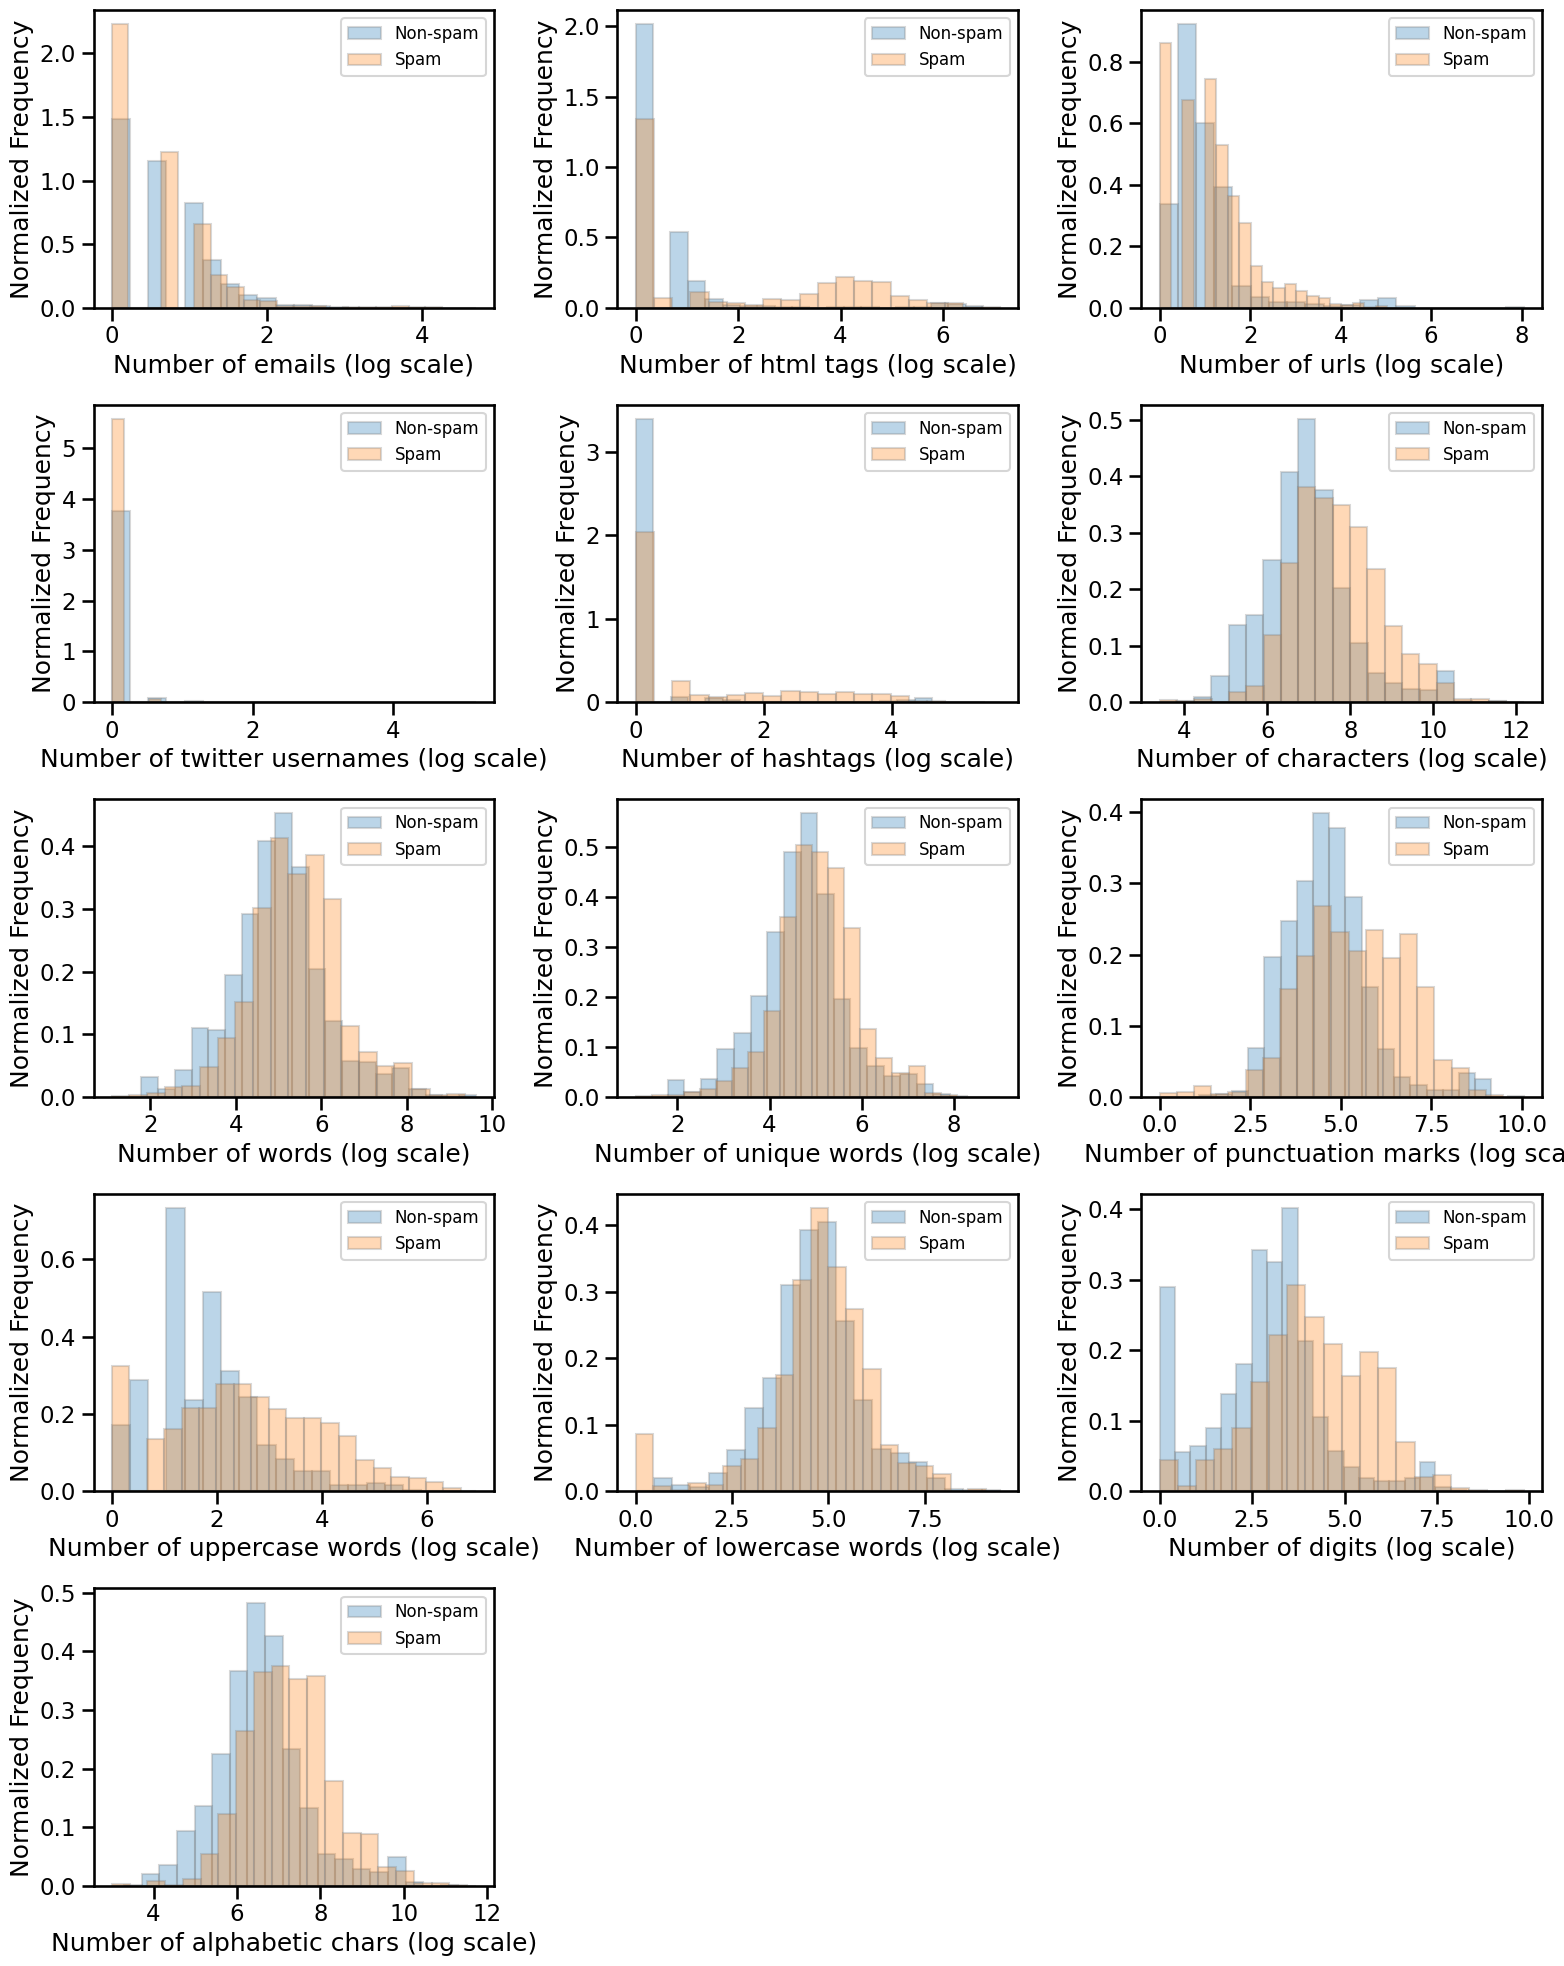

In [8]:
features = tools.get_features(df=df)

## **(4) Feature Engineering**

### Extraktion von Merkmalen aus Text
Computer verstehen keine natürliche Sprache. Wie stellen wir also Text dar?  
Eines der einfachsten, aber effektiven und häufig verwendeten Modelle zur Darstellung von Texten für das maschinelle Lernen ist das [**Bag of Words Modell**](https://en.wikipedia.org/wiki/Bag-of-words_model). Wenn wir dieses Modell verwenden, verwerfen wir den Großteil der Struktur des Eingangstextes (Wortreihenfolge, Kapitel, Absätze, Sätze und Formatierung) und zählen nur, wie oft jedes Wort in jedem Text vorkommt. Das Verwerfen der Struktur und das Zählen nur der Wortvorkommen führt zu dem mentalen Bild, Texte als "Beutel" darzustellen.  
**Übung:** Unser Beispielkorpus soll vier Dokumente enthalten.

$ corpus = ['I\;enjoy\;paragliding.',  $  
$\hspace{2cm}'I\;like\;NLP.',$  
$\hspace{2cm}'I\;like\;deep\;learning.',$  
$\hspace{2cm}'O\;Captain!\;my\;Captain!']$

In [9]:
# Darstellung des Bag of Word Vektors
tools.show_bag_of_words_vector()

,captain,deep,enjoy,i,learning,like,my,nlp,o,paragliding
Text,,,,,,,,,,
I enjoy paragliding.,0,0,1,1,0,0,0,0,0,1
I like NLP.,0,0,0,1,0,1,0,1,0,0
I like deep learning.,0,1,0,1,1,1,0,0,0,0
O Captain! my Captain!,2,0,0,0,0,0,1,0,1,0


Bag of Words hat alle Dokumente in numerische Vektoren umgewandelt. Jede Spalte repräsentiert ein Wort aus dem Korpus und jede Zeile eines der vier Dokumente. Der Wert in jeder Zelle repräsentiert die Anzahl der Vorkommen dieses Wortes in einem bestimmten Dokument. Zum Beispiel enthält das vierte Dokument das Wort `captain` (Kapitän) zweimal und die Wörter `my` (mein) und `Oh` (O) jeweils einmal.

## **(5) Aufbau eines Spam-Detektors**

Im vorhergehenden Abschnitt haben wir gesehen, wie man Textvorverarbeitung und Merkmalsextraktion aus Texten durchführt. Jetzt sind wir bereit, unser maschinelles Lernmodell zur Erkennung von Spam zu entwickeln. Wir werden einen Klassifikator nutzen, der auf [logistischer Regression](https://en.wikipedia.org/wiki/Logistic_regression) basiert.  
Zuerst müssen wir die Daten in zwei Sätze aufteilen: den `Trainingssatz` und den `Testsatz`. Wir werden dann den Trainingssatz nutzen, um unser Modell zu `trainieren`. Der Testsatz wird verwendet, um die Leistung unseres Modells zu `bewerten`.

### 5.1 Spam Klassifizierung

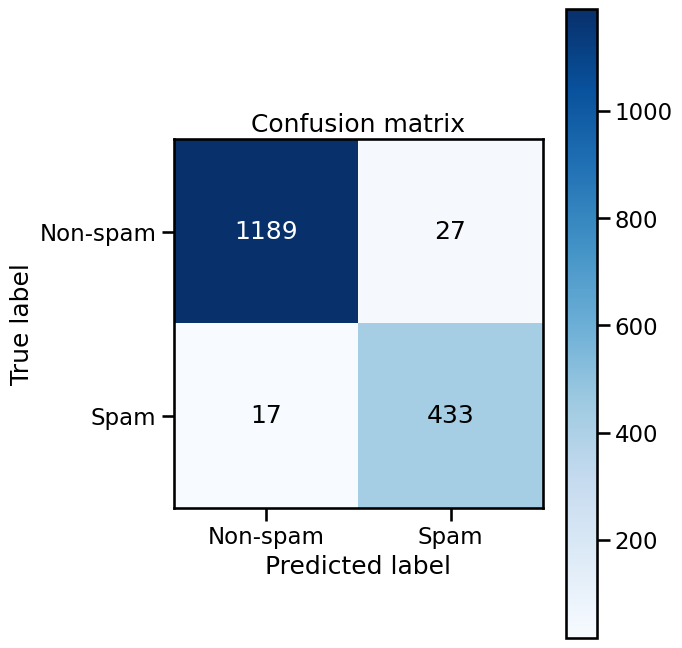

In [10]:
# "Train-Test Splitting": Aufteilung in einen Train und einen Test Datensatz
df_train, df_test = tools.train_test_split_(df)
# "Model fitting" auf die Trainingsdaten
model = tools.fit_model(df_train)
# Vorhersagen für das Testset anzeigen lassen
tools.plot_confusion_matrix(df_test,model);

**Confusion Matrix**  
Konfusionsmatrizen sind eine gute Möglichkeit, die Leistung von Klassifikationsmodellen zu bewerten. Zeilen entsprechen den tatsächlichen Klassen und Spalten den vorhergesagten Klassen. Einträge auf der Hauptdiagonale der [Konfusionsmatrix](https://en.wikipedia.org/wiki/Confusion_matrix) entsprechen korrekten Vorhersagen, während die anderen Zellen uns zeigen, wie viele Fehler unser Modell gemacht hat.  
* Die erste Zeile repräsentiert Nicht-Spam-Mails: 1.187 wurden korrekt als 'Nicht-Spam' klassifiziert, während 29 (~2,3 %) fälschlicherweise als 'Spam' klassifiziert wurden.
* Die zweite Zeile repräsentiert Spam-Mails: 437 wurden korrekt als 'Spam' klassifiziert, während 13 (~2,8 %) fälschlicherweise als 'Nicht-Spam' klassifiziert wurden.  
Unser Modell hat ziemlich gut abgeschnitten!

## **(6) Was hat unser Model von den Daten gelernt?**

### 6.1 Top 30 Features für Spam und Nicht-Spam

Unser Modell der logistischen Regression hat gelernt, welche Wörter am aussagekräftigsten für Nicht-Spam und welche am aussagekräftigsten für Spam sind. Die positiven Koeffizienten auf der rechten Seite entsprechen Wörtern, die laut Modell auf Spam hinweisen. Die negativen Koeffizienten auf der linken Seite entsprechen Wörtern, die laut Modell auf Nicht-Spam hinweisen.

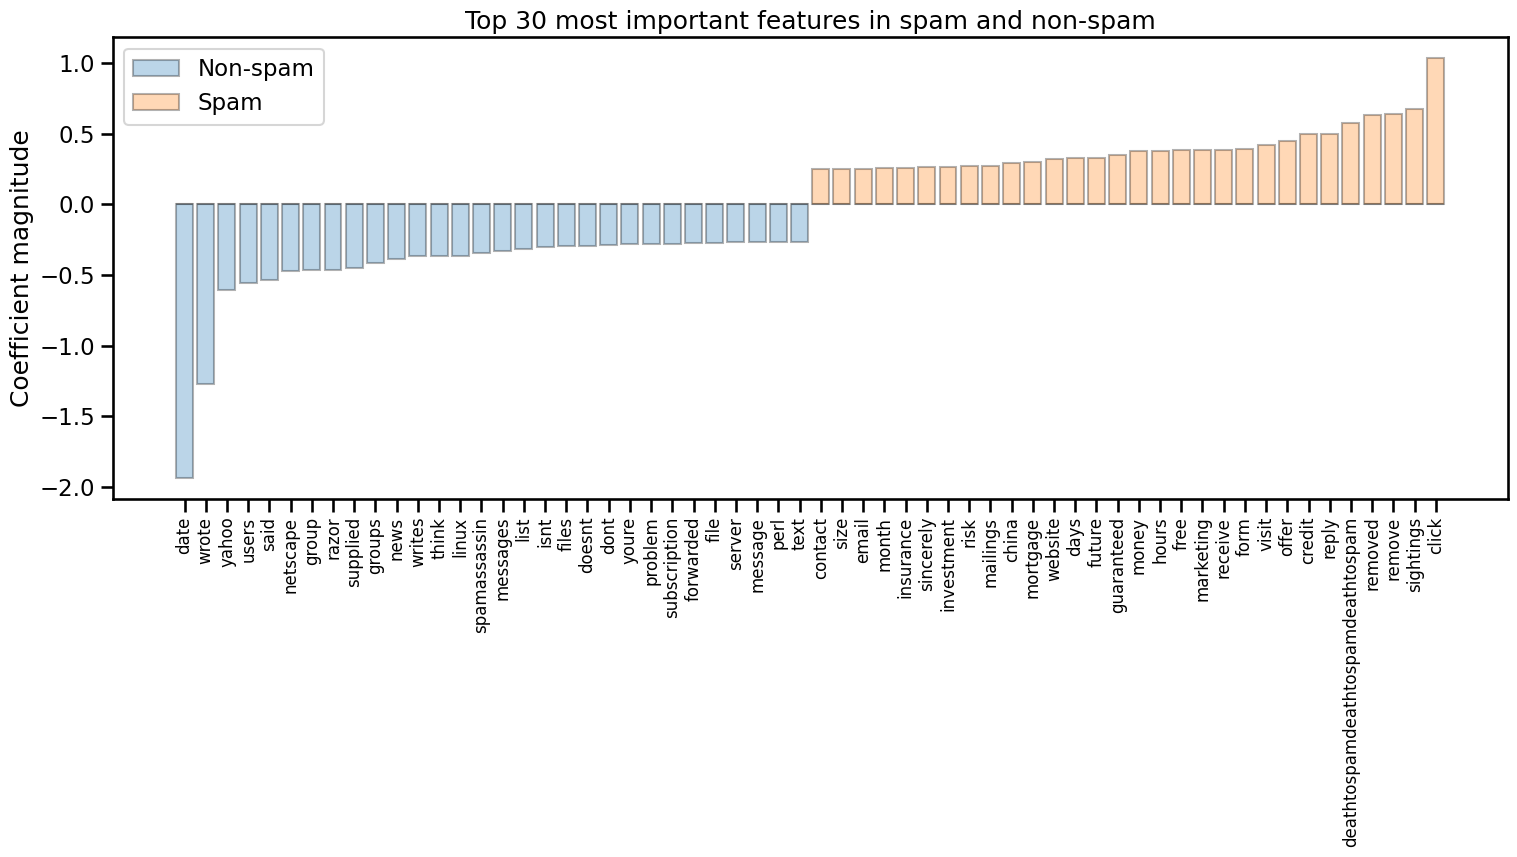

In [14]:
# Visualisierung anhand der Koeffizienten. Passen Sie gerne n_top_feautures an.
tools.visualize_coefficients(model, n_top_features=30)

Unserem Model zu Folge sind Wörter wie "date", "wrote", "yahoo", "said", "linux", "author", usw. starke Indikatoren für Nicht-Spam E-Mails.  

Wörter wie "click", "credit", "remove", "free", "offer", "money", usw. sind unserem Model zu Folge dagegen indikativ für Spam.

### 6.2 Fehleranalyse

Wir werden nun die falsch klassifizierten Mails analysieren, um Einblicke zu gewinnen, warum das Modell keine korrekten Vorhersagen treffen konnte. Die unten stehende *Fehleranalyse*-Funktion wird uns die wichtigsten Merkmale zeigen, die dafür verantwortlich sind, dass das Modell die Entscheidung getroffen hat, ob eine Mail als Spam oder Nicht-Spam vorhergesagt wird.

Document index: 16 


Original Text
Welcome to "Ghetto" America! ...Yes, you heard me; I said "Ghetto" America! What is "Ghetto"
America, I'm glad you asked. Before I go on please be warned,  this explanation may not sit well
with many of you, however it is  no less true! "Ghetto" America is a society of individuals
comprised primarily of African Americans who represent the  impoverished, and often unpolished side
of "Black America;"  Confused?! I shall explain further; have you ever passed by a  typical ghetto
community; namely the "projects" and noticed an  unusual amount of fancy cars parked throughout that
particular  neighborhood, and wondered how could that be? Or maybe you have  been to a shopping
mall, and noticed an unusual amount of young  "teen looking" black women carrying infants, or
pushing baby  carriages and often with a toddler in tow! Perhaps you also  noticed that there was
rarely any male companion accompanying  them. If you paid close attention you might have also

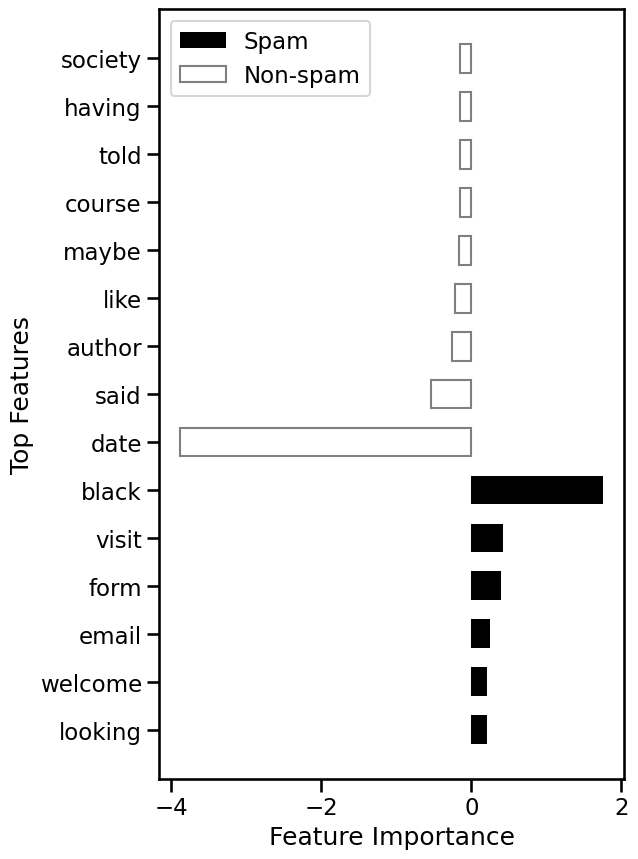

In [15]:
# Visualisierung der Fehleranalyse
tools.error_analysis(df_test,model,doc_nbr=16)

# Glückwunsch!
## Sie haben Spam mit Ihrem eigenen Machine Learning Model erfolgreich identifiziert.

Referenzen:
- Xydi, Panagiota (2020): Text classification hands-on exercise, EPFL Extension School Workshop, Applied Machine Learning Days.
- Müller, Andreas C.; Guido, Sarah (2017): Introduction to Machine Learning with Python. A Guide for Data Scientists. O’Reilly Sebastopol, CA. Chapter 7. Working with Text Data, p. 329-362.
- Datensatz: [Apache Spam Assassin](https://spamassassin.apache.org) enthält ca. 6.000 gelabelte E-Mails mit einem Spam-Anteil von etwa 30 %.
- Helferfunktionen: [Hertie Modul 3 GitHub](https://github.com/janbatzner/Hertie_KI-Modul_SPAM_Classifier)